# Gath - Geva Clustering

In [12]:

!pip install -U scikit-learn

First thing first, let's use the generator tools from previous works

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.cluster import AgglomerativeClustering as agg

def get_random_covariance(d):
    """
    Function to generate a random, valid covariance matrix of size d x d
    """
    sigma = np.random.rand(d, d) - 0.5
    sigma = np.dot(sigma, sigma.T)  # make the matrix symmetric
    return sigma


def get_random_gaussian_dist(d, distance=5):
    """
     generate a random Gaussian distribution with mean mu and covariance matrix sigma
    The distance parameter specifies the distance of the mean from the origin
    """
    sigma = get_random_covariance(d)  # generate a random covariance matrix
    mu = np.array(np.random.rand(d)) * distance  # generate a random mean
    return mu, sigma


def generate_normal_datapoint(guaussian_dist):
    """
     generate a single datapoint from a Gaussian distribution with mean and covariance matrix guaussian_dist
    """
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov, check_valid='warn', tol=1e-8)
    return dp


def generate_gaussian_cluster(guaussian_dist, k,d = 2, dataset=None):
    """
    Function to generate a cluster of k datapoints from the Gaussian distribution guaussian_dist
    The dataset parameter can be used to append the generated cluster to an existing dataset
    gauss_dist is a tuple of the form (mean, covariance matrix)
    """
    cluster = np.empty((0, d))  # initialize an empty array to store the datapoints
    for i in range(k):
        p = generate_normal_datapoint(guaussian_dist)  # generate a single datapoint
        cluster = np.append(cluster, [p], axis=0)  # add the datapoint to the cluster
    if dataset:
        dataset = np.append(dataset, cluster)  # append the cluster to an existing dataset, if provided
    return cluster


def plot_loss(loss):
    plt.figure()
    plt.plot(range(len(loss)),loss)
    plt.title("loss vs. iteration no.")
    plt.xlabel("iteration")
    plt.ylabel("|loss|")
    plt.show()

def get_rand_centroids(K,d):
    centroids = np.random.rand(K, d)
    return centroids

In [20]:

def generate_clusters(k, d = 2,N = 600, distance = 2):
    """
    generate k clusters of d-dimensional data

    :param k:           number of clusters
    :param d:           dimension of the data
    :param distance:    expected distance of the mean from the origin
    :return:            clusters - a list of clusters, where each cluster is a numpy array of datapoints
                        data - a numpy array of all the datapoints
                        phi - a numpy array of the priors of each cluster
                        sigma - a numpy array of the covariance matrices of each cluster
    """
    phi = np.random.rand(k)
    phi = phi/np.sum(phi)
    print(phi)

    # random distributions
    distributions = [get_random_gaussian_dist(d,distance) for i in range(k)]
    print(distributions[0])
    # generate clusters
    clusters = [generate_gaussian_cluster(distribution,int(phi[i]*N),d) for i, distribution in enumerate(distributions)]

    sigma = [distribution[1] for distribution in distributions]
    data = np.concatenate(clusters,axis=0)

    return clusters, data, phi, sigma



def plot_clusters(clusters, d = 2,title = None):

    """
    Function to plot the clusters
    input: clusters - a list of clusters, where each cluster is a numpy array of datapoints
           d - the dimension of the data
    output: a plot of the clusters, where each cluster is a different color, and the datapoints are transparent to show overlapping clusters

    """
    plt.figure()
    if d == 2:
        for c in clusters:
            plt.scatter(c[:,0], c[:, 1], alpha=0.5)
    else:
        for c in clusters:
            ax = plt.axes(projection='3d')
            ax.scatter3D(c[:,0], c[:, 1], c[:, 2], alpha=0.5)
    if title:
        plt.title(title)


def plot_centroids(centroids, d = 2,title = None):
    """
    Function to plot the centroids
    input: centroids - a numpy array of centroids
           d - the dimension of the data
    output: a plot of the centroids, where each centroid is a different color

    """
    if d == 2:
        for c in centroids:
            plt.scatter(c[0],c[1],marker='x',s=100)
    else:
        for c in centroids:
            ax.scatter3D(c[0], c[1], c[2], marker='x', s=100)



In [21]:
def get_gaussian_line_shape_distribution(p1,p2):
    v = p2 - p1
    v_norm = np.linalg.norm(v)
    u = v/v_norm

    sigma = v_norm * np.outer(u,u)

    epsilon = 0.005 * np.identity(sigma.shape[0])
    sigma +=epsilon

    mu = p1 + (p2 - p1)/2

    return mu, sigma



## generate the data

In [58]:

K = 4
d = 2
N = 1000
distance = 6
max_iters = 50
fuzziness = 2

clusters, data, phi, sigma = generate_clusters(K,d,N=N,distance=distance)

[0.26480334 0.27542899 0.30390313 0.15586454]
(array([3.57426382, 1.93547773]), array([[ 0.22142673, -0.12397431],
       [-0.12397431,  0.0916832 ]]))


## plot the data

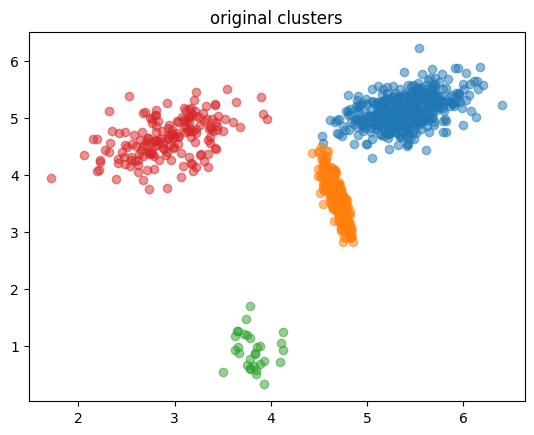

In [27]:
plot_clusters(clusters,d,title="original clusters")

# Agglomerative clustering

Aggumulative clustering is a bottom-up approach to clustering. The algorithm starts with each datapoint as a cluster, and then merges the two closest clusters iteratively until the desired number of clusters is reached, according to some distance metric.

the algorithm runs acording to the following pseudo-code:
##### Input:

- data: A set of n data points, where data = {x1, x2, ..., xn}
- distance_function: A function that calculates the distance between two clusters, for example, d(ci, cj) denotes the distance between clusters ci and cj.
##### Output:

- clusters: A set of clusters obtained from the agglomerative clustering algorithm.

##### Initialization:

Initialize $n$ clusters, each containing a single data point: $ci = {xi}$ for $i /belongs \{1... n\}$.
Compute the distance matrix D with D[i, j] = distance_function(ci, cj) for all pairs of clusters.

##### Agglomerative Cluster($K$, data $x$, distance_function $f$):
While the number of clusters is greater than 1, do the following:

1. Find the two closest clusters ca and cb based on the distance matrix $D$:
$$c_a, c_b = argmin_{c_i, c_j} D[i, j]$$

2. Merge the closest clusters $c_a$ and $c_b$ into a new cluster c_new:
$$c_{new} = c_a ∪ c_b$$

3. Update the distance matrix $D$ to reflect the new distances between the merged cluster $c_new$ and the remaining clusters:
$D[new, k]$ = $f(c_{new}, c_k)$ for all clusters ck in the remaining clusters

Remove the rows and columns corresponding to $c_a$ and $c_b$ from $D$.

##### Output:
Return the final set of clusters after the algorithm terminates.



In [56]:
def agglomerative_cluster(data, K, linkage='ward'):
    """
    :param data:
    :param n_clusters:
    :param linkage:
    :return:
    """
    clustering = agg()
    clustering.n_clusters = K
    clustering.linkage = linkage
    clustering.fit(data)

    labels = clustering.labels_

    clusters = [data[labels == i] for i in range(K)]
    plot_clusters(clusters,d,title="Agglomerative clustering")
    return clusters

def agglomerative_cluster_plot_steps(data, K, linkage='ward'):
    """
    :param data:
    :param n_clusters:
    :param linkage:
    :return:
    """
    clustering = agg()
    n_steps = 10
    steps = [K + 5*(n_steps-1-k) for k in range(n_steps)]
    for k in range(len(steps)):
        clustering.n_clusters = steps[k]
        clustering.linkage = linkage
        clustering.fit(data)
        labels = clustering.labels_

        clusters = [data[labels == i] for i in range(steps[k])]
        plot_clusters(clusters,d,title="Agglomerative clustering")
        plt.pause(0.5)
        plt.clf()

    # clustering.n_clusters = K
    # clustering.linkage = linkage
    # clustering.fit(data)
    #
    # labels = clustering.labels_
    #
    # clusters = [data[labels == i] for i in range(K)]
    # plot_clusters(clusters,d,title="Agglomerative clustering")
    return clusters

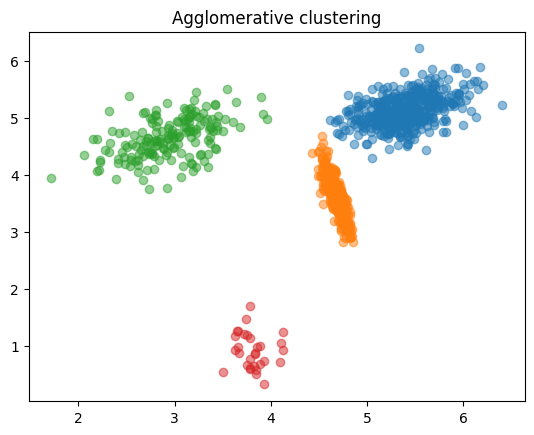

In [36]:

clusters = agglomerative_cluster(data,K)



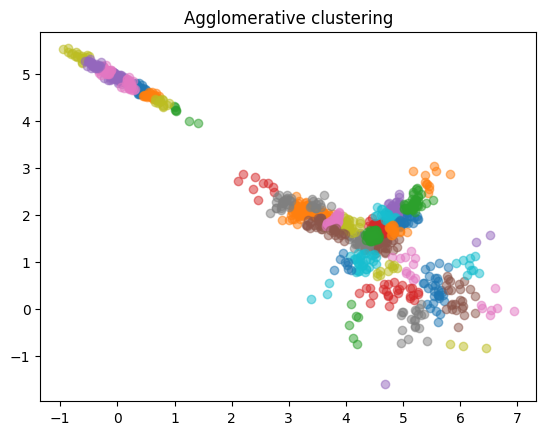

<Figure size 640x480 with 0 Axes>

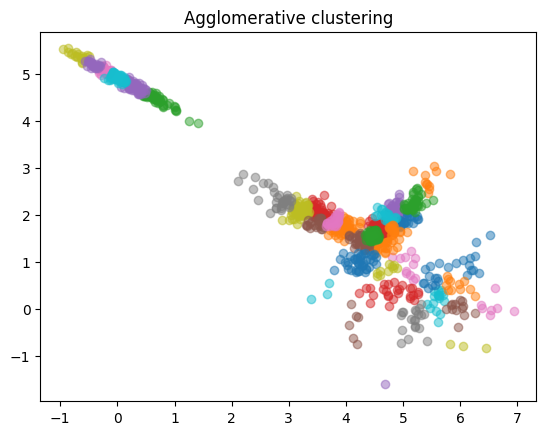

<Figure size 640x480 with 0 Axes>

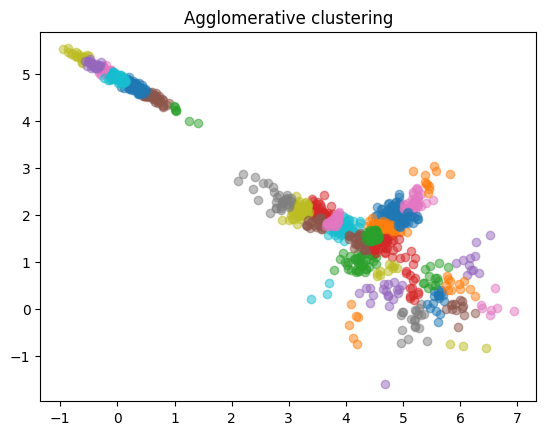

<Figure size 640x480 with 0 Axes>

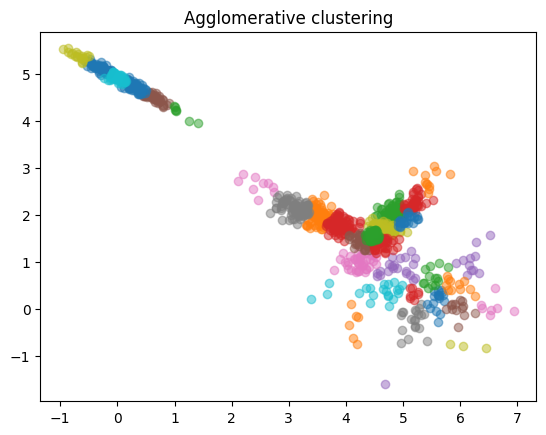

<Figure size 640x480 with 0 Axes>

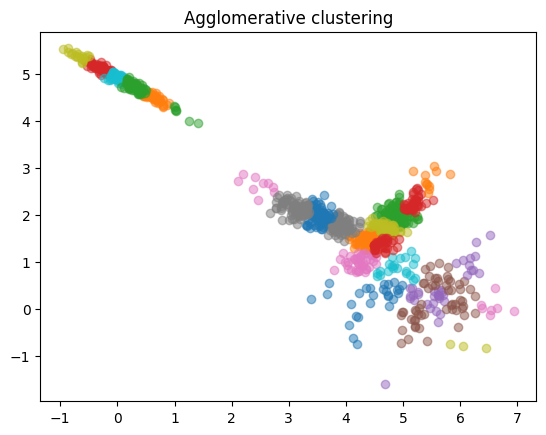

<Figure size 640x480 with 0 Axes>

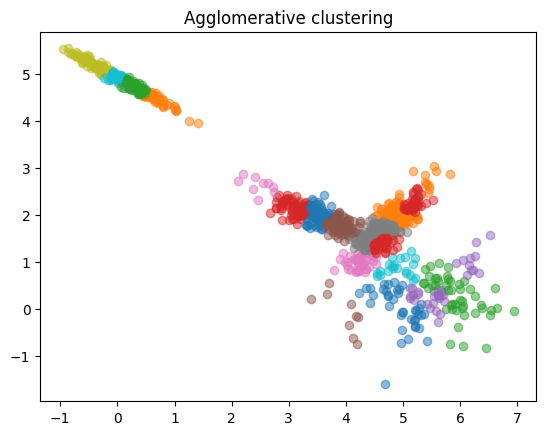

<Figure size 640x480 with 0 Axes>

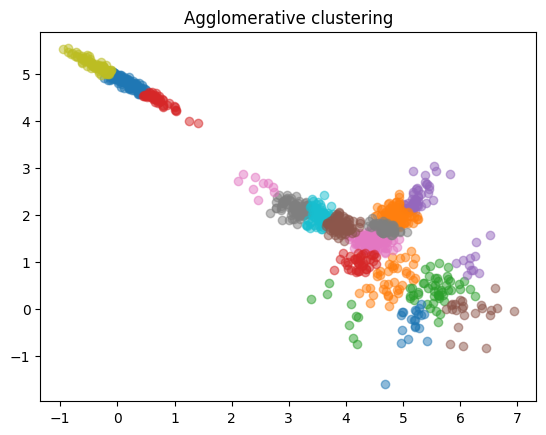

<Figure size 640x480 with 0 Axes>

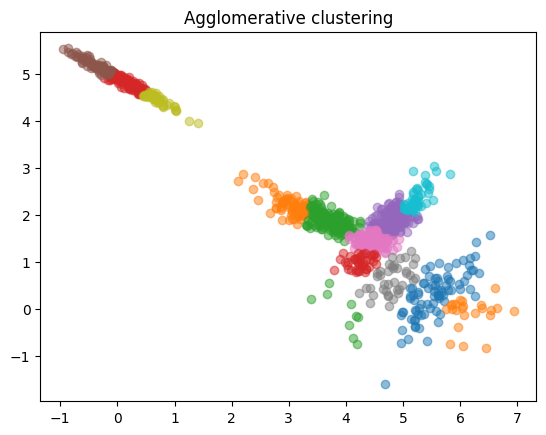

<Figure size 640x480 with 0 Axes>

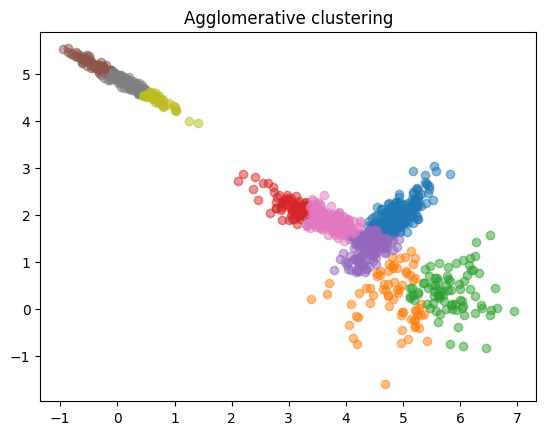

<Figure size 640x480 with 0 Axes>

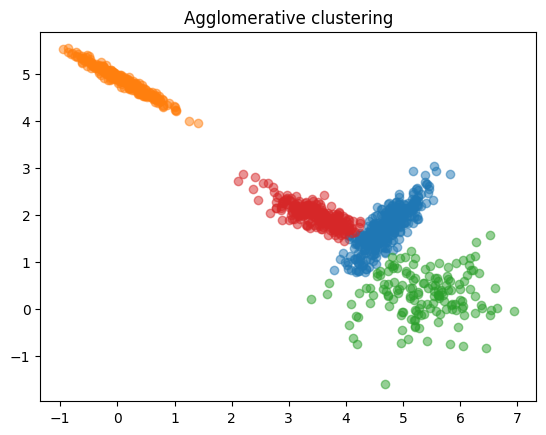

<Figure size 640x480 with 0 Axes>

In [59]:

clusters = agglomerative_cluster_plot_steps(data,K)

# K-Means with exponential kernel
The K-Means with exponential kernel algorithm is a variant of the K-Means algorithm that is used to cluster data points $\{x_i\}_1^n$ when the initialization centers $\{c_j\}_1^n$ are not known, but with known number of clusters $K$ .

## generate the data

In [43]:

K = 7
d = 2
N = 1000
distance = 10

clusters, data, phi, sigma = generate_clusters(K,d,N=N,distance=distance)

[0.08484238 0.17550648 0.27400682 0.04548459 0.11246285 0.15407688
 0.15362   ]
(array([2.69423895, 0.83825441]), array([[ 0.26507731, -0.17938542],
       [-0.17938542,  0.12207065]]))


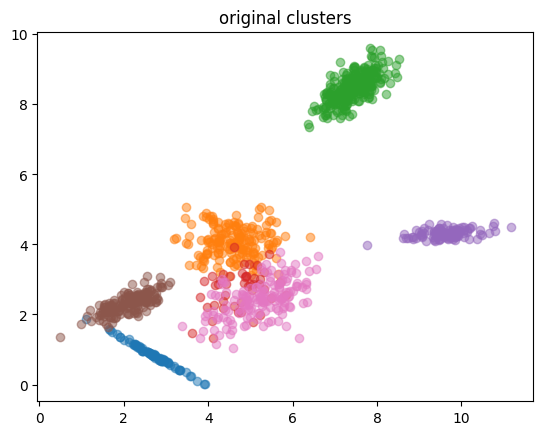

In [44]:
plot_clusters(clusters,d,title="original clusters")

## try the algorithm

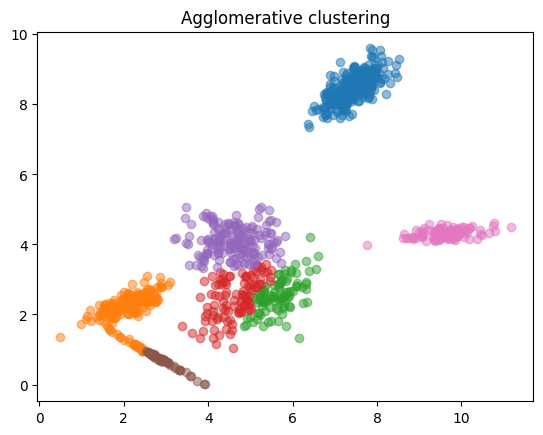

In [45]:
clusters = agglomerative_cluster(data,K)


# RUn the algorithm with the trace criterion

## results

## The determinant criterion
the determinant criterion is a cluster validity criteria that is used to evaluate the quality of a clustering partition by estimating the volume of the distribution. the determinant criterion is defined as:
$$V = det \left(\frac{1}{N_k}\sum_{i=1}^N (x_i - c_k)\cdot(x_i - c_k)^t\right)$$
where $N_k$ is the number of data points in cluster $k$.